In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from scipy.stats import pearsonr

# Fig 1D: presence, abundance, and prevalence of species at baseline

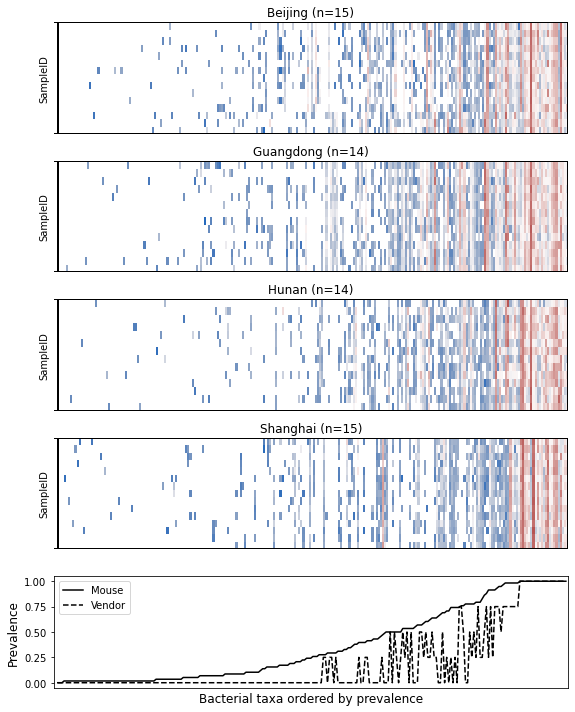

In [2]:
# read meta data
df_meta = pd.read_csv('meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Day == 0] # baseline microbiota

# read bacterial abundance
df_bac = pd.read_csv('16S_relative_abundance_species.csv', index_col=0)
df_bac = df_bac.loc[df_meta.index]

# remove species that are not present in all baseline
df_bac = df_bac.loc[:, (df_bac != 0).any(axis=0)]
df_bac_mask = (df_bac >= 1e-5).astype(int) # add mask (1 represents presence)

# compute prevalence score in mice and sort bacterial taxa based on the score
df_bac_mask_T = deepcopy(df_bac_mask.T)
df_bac_mask_T['mean'] = df_bac_mask_T.mean(axis=1)
df_bac_mask_T = df_bac_mask_T.sort_values('mean')
df_prevalence_mice = df_bac_mask_T[['mean']].rename({'mean':'prevalence'}, axis=1)
df_bac_mask = df_bac_mask_T.drop('mean', axis=1).T
df_bac = df_bac.loc[df_bac_mask.index, df_bac_mask.columns]
df_bac_log = np.log10(df_bac)

# prevalence in vendor (at least one sample)
df_bac_mask_vendor = pd.merge(df_bac_mask, df_meta[['Vendor']], left_index=True, right_index=True, how='left').groupby('Vendor').agg('mean')
df_bac_mask_vendor = (df_bac_mask_vendor>0.001).astype(int)
df_bac_mask_vendor_T = df_bac_mask_vendor.T
df_prevalence_vendor_loose = df_bac_mask_vendor_T.mean(axis=1).to_frame().rename({0:'prevalence'},axis=1)

# prevalence in vendor (all samples)
df_bac_mask_vendor = pd.merge(df_bac_mask, df_meta[['Vendor']], left_index=True, right_index=True, how='left').groupby('Vendor').agg('mean')
df_bac_mask_vendor = (df_bac_mask_vendor>0.999).astype(int)
df_bac_mask_vendor_T = df_bac_mask_vendor.T
df_prevalence_vendor_stringent = df_bac_mask_vendor_T.mean(axis=1).to_frame().rename({0:'prevalence'},axis=1)

# plot heatmap
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8,10), sharex=True)
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    sample_indices = list(df_meta[df_meta.Vendor==vendor].index)
    _ = sns.heatmap(df_bac_log.loc[sample_indices], 
                    ax=ax[k], 
                    cbar=False, 
                    xticklabels=[],
                    yticklabels=[],
                    cmap="vlag",
                    mask=(df_bac_mask^1).loc[sample_indices],
                    vmin=-5,
                    vmax=0
                   )
    _ = ax[k].set_title('%s (n=%d)'%(vendor, len(sample_indices)))
    _ = ax[k].tick_params(left=False, bottom=False)
    
    # Drawing the frame
    ax[k].axhline(y = 0, color='k',linewidth = 2)
    ax[k].axhline(y = df_bac_log.loc[sample_indices].shape[0], color = 'k', linewidth = 2)
    ax[k].axvline(x = 0, color = 'k', linewidth = 2)
    ax[k].axvline(x = df_bac_log.loc[sample_indices].shape[1], color = 'k', linewidth = 2)
    
_ = ax[4].plot(df_prevalence_mice, 'k-', label='Mouse')
_ = ax[4].plot(df_prevalence_vendor_stringent, 'k--', label='Vendor')
_ = ax[4].legend()
_ = ax[4].set_xlim([-2,len(df_prevalence_mice.index)])
_ = ax[4].set_xticks([])
_ = ax[4].set_xticklabels([])
_ = ax[4].tick_params(bottom=False)
_ = ax[4].set_ylabel('Prevalence', fontsize=12)
_ = ax[4].set_xlabel('Bacterial taxa ordered by prevalence', fontsize=12)

plt.tight_layout()

# Plot relationship between abundance and prevalence

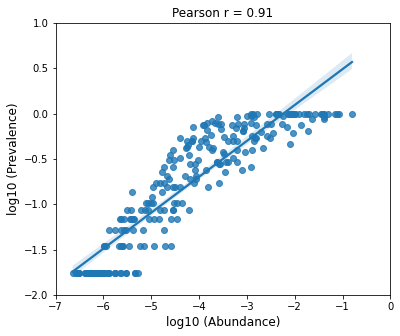

In [4]:
df_bac_abun_prev = pd.merge(df_bac.mean().to_frame().rename({0:'abundance'},axis=1), df_prevalence_mice, left_index=True, right_index=True, how='inner')
df_bac_abun_prev = np.log10(df_bac_abun_prev)
df_bac_abun_prev = df_bac_abun_prev[df_bac_abun_prev.prevalence != -np.inf]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
_ = sns.regplot(x='abundance', y='prevalence', data=df_bac_abun_prev, ax=ax)
_ = ax.set_title('Pearson r = %2.2f'%(pearsonr(df_bac_abun_prev.abundance, df_bac_abun_prev.prevalence)[0]))
_ = ax.set_xlim([-7,-0])
_ = ax.set_ylim([-2,1])
_ = ax.set_xlabel("log10 (Abundance)", fontsize=12)
_ = ax.set_ylabel("log10 (Prevalence)", fontsize=12)